In [796]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim

import pywavefront
import numpy as np


def get_vert_np():
    obj = 'truck.obj'
#     obj = 'block.obj'
#     obj = 'monkey.obj'
#     obj = 'long.obj'
    scene = pywavefront.Wavefront(obj, parse=True)
    return np.array(scene.vertices)

vert_np = get_vert_np()
num_grid_dim = int((vert_np.shape[0]//np.sqrt(vert_np.shape[0])))
ind = num_grid_dim**2
vert_np = vert_np[:ind,:]
verts = torch.tensor(vert_np,dtype=torch.float32, device='cuda')

x = np.linspace(0, 1, num_grid_dim)
y = np.linspace(0, 1, num_grid_dim)
xv, yv = np.meshgrid(x, y, indexing='xy')
verts_grid = torch.tensor(np.stack((xv.flatten(), yv.flatten()), axis=1), dtype=torch.float32, device='cuda')

In [797]:


class UVNet(nn.Module):
    def __init__(self):
        super(UVNet, self).__init__()
        self.bn1 = nn.BatchNorm1d(3)
        width = 256
        self.fc1 = nn.Linear(6*3*0 + 3, width)
        self.fc2 = nn.Linear(width, width)
        self.fc21 = nn.Linear(width, width)
        self.fc3 = nn.Linear(width, 2)
        self.bn2 = nn.BatchNorm1d(2)
        self.fc4 = nn.Linear(24*2 + 2, width)
        self.fc5 = nn.Linear(width, width)
        self.fc51 = nn.Linear(width, width)
        self.fc52 = nn.Linear(width, width)
        self.fc53 = nn.Linear(width, width)
        self.fc54 = nn.Linear(width, width)
        self.fc6 = nn.Linear(width, 3)
        
    def encode(self, x):
        batch_size = x.size()[0]
#         features = [x]
#         features.extend([torch.sin(i*x) for i in range(1, 12+1, 2)])
#         x = torch.concatenate(features, axis=1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
#         x = F.leaky_relu(self.fc21(x))
        uv = F.leaky_relu(self.fc3(x))
        u_norm = (uv[:,0]-uv[:,0].min())/(uv[:,0].max() - uv[:,0].min())
        v_norm =  (uv[:,1]-uv[:,1].min())/(uv[:,1].max() - uv[:,1].min())
        uv = torch.concatenate([u_norm.view(-1,1), v_norm.view(-1,1)], axis=1)
        return uv
        
    def decode(self, uv):
#         x = torch.concatenate([torch.cos(3.14*uv), torch.sin(3.14*uv)],axis=1)
        features = [uv]
        features.extend([torch.sin(.1*3.14*i*uv) for i in range(1, 24+1, 1)])
        x = torch.concatenate(features, axis=1)
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc52(x))    
#         x = F.leaky_relu(self.fc53(x))
#         x = F.leaky_relu(self.fc54(x))
        points = self.fc6(x)
        return points 
        
        
    def forward(self, x):
        uv = self.encode(x)
        points = self.decode(uv)
        
        return points, uv

def compute_loss(pred_points, target_points, uv, target_grid):
    loss = F.huber_loss(pred_points, target_points)
#     loss = (abs(pred - target)).sum()
#     loss = 1*((pred_points - target_points)**2).sum()/torch.numel(pred_points)
#     loss2 = .1*((uv - target_grid)**2).sum()/torch.numel(target_grid)
#     print(uv - target_grid)
    #     loss = (abs(pred - target)).sum()/torch.numel(pred)
#     tmp, _= torch.max(abs(pred - target), dim=0)
#     tmp, _= torch.max(tmp, dim=0)
#     loss2 = 10*tmp.sum()/pred.shape[1]
#     loss = loss + loss2
    return loss
    
network = UVNet()
network.cuda(device='cuda')

UVNet(
  (bn1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc21): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
  (bn2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=50, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=256, bias=True)
  (fc51): Linear(in_features=256, out_features=256, bias=True)
  (fc52): Linear(in_features=256, out_features=256, bias=True)
  (fc53): Linear(in_features=256, out_features=256, bias=True)
  (fc54): Linear(in_features=256, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=3, bias=True)
)

In [798]:
lr = 5e-2 #abs
# lr = 1e-2 # huber
momentum = 0.99



optimizer = optim.SGD(network.parameters(), lr=lr, momentum=momentum)

for it in range(0, 20000):
    optimizer.zero_grad()
    pred_verts, uv = network(verts)
    loss_train = compute_loss(pred_points=pred_verts, target_points=verts,uv=uv, target_grid=verts_grid)
    if it % 1000 == 0:
        print(loss_train)
    loss_train.backward()
    optimizer.step()
    
    
    

tensor(0.0043, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(3.2013e-05, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(1.8056e-05, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(9.8336e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(6.5212e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(5.0801e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(4.2757e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(3.7580e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(3.3727e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(3.0860e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(2.8585e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(2.6734e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(2.5141e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(2.3743e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(2.2533e-06, device='cuda:0', grad_fn=<HuberLossBackward0>)
tensor(2.1447e

[[8.94814730e-05 3.09001654e-04 7.92924315e-04]
 [1.21157616e-04 1.03361905e-04 9.77762043e-04]
 [3.71381640e-04 3.91855836e-04 4.42757271e-04]
 ...
 [4.45157290e-04 3.64501029e-04 9.29567963e-04]
 [1.02591515e-03 1.58452615e-03 1.07941777e-03]
 [1.13391876e-03 2.05614604e-03 1.80438533e-03]]
(10816, 3)


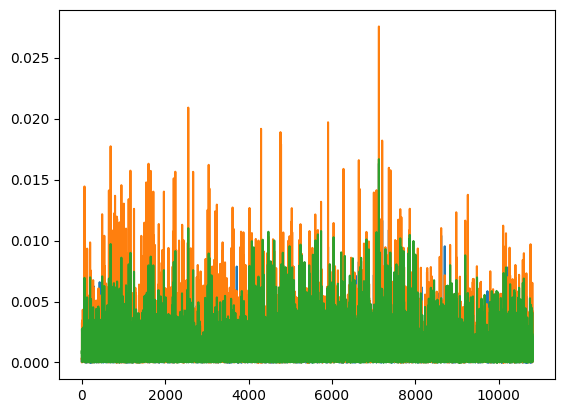

In [799]:
from matplotlib.pyplot import plot as plot
tmp = (abs(verts - pred_verts)).cpu().detach().numpy()
 
print(tmp)
print(tmp.shape)

plot(tmp[:,0])
plot(tmp[:,1])
plot(tmp[:,2])

In [800]:
from matplotlib.pyplot import scatter as scatter

uv_np = uv.cpu().detach().numpy()

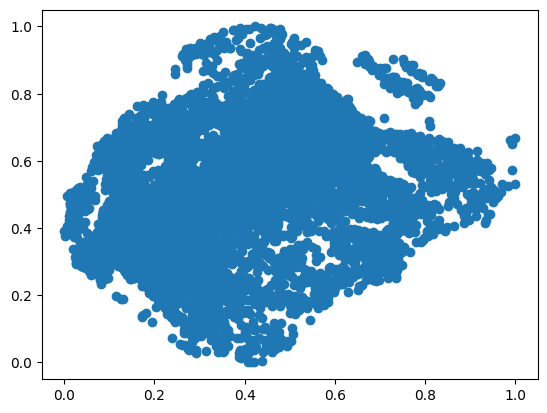

In [801]:
scatter(uv_np[:, 0], uv_np[:, 1])

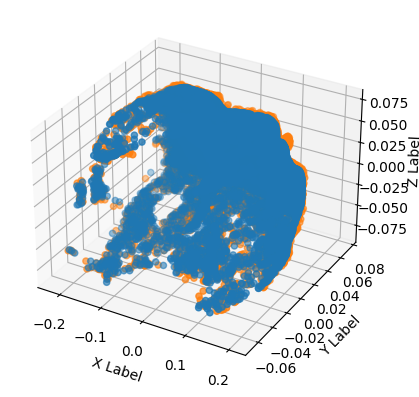

In [802]:
import matplotlib.pyplot as plt

pred_np = pred_verts.cpu().detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(pred_np[:, 0], pred_np[:, 1], pred_np[:, 2])
ax.scatter(vert_np[:, 0], vert_np[:, 1], vert_np[:, 2])


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [803]:
import os
import sys
import rclpy
if '/home/paul/CLionProjects/thesis_nerf/scripts' not in sys.path:
    sys.path.append('/home/paul/CLionProjects/thesis_nerf/scripts')
if not rclpy.ok():
    rclpy.init()
from point_cloud_utils import send_point_cloud
    

def send_points(points, color, topic):
    colors = np.zeros(points.shape)+color 
    rgb_points = np.hstack((points, colors))
    send_point_cloud(rgb_points, has_alpha=False,topic=topic)
    
    
send_points(pred_np, np.array([0,1,0]),topic='point_cloud_2')


In [804]:
send_points(vert_np, np.array([.7,.7,.7]),topic='point_cloud')

In [805]:
network.eval()
uv_np = uv.cpu().detach().numpy()

x = np.linspace(np.min(uv_np[:,0]), np.max(uv_np[:,0]), 100)
y = np.linspace(np.min(uv_np[:,1]), np.max(uv_np[:,1]), 100)
xv, yv = np.meshgrid(x, y, indexing='xy')
verts_grid_new = torch.tensor(np.stack((xv.flatten(), yv.flatten()), axis=1), dtype=torch.float32, device='cuda')
verts_grid_new.shape
pred_grid = network.decode(verts_grid_new)
pred_grid_np = pred_grid.cpu().detach().numpy()
send_points(pred_grid_np, np.array([0,0,1]),topic='point_cloud_2')

In [549]:
vert_np.shape

(10816, 3)